In [2]:
import os
import glob
import yaml
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from numpy.random import randn as rd
from scipy.interpolate import interp1d

# Prepare for the Tardis
In this notebook, I will prepare the element structure file and yaml file to run the Tardis.  
To notice, although the "element structure" in Tardis document is the relative element ratio, the sum of all element mass in one zone doesn't necessary to be one.  
More importantly, doing such manipulation is effectively changing the density.  
So, I don't force the element ratio to be sum 1, then all the Tardis can use a same density file but still change the density.  


Okay, let us get it started.  

## Take a look at our base model
The Initial Guess (IG) model, I previously call it "manipulated deflagration-detonation" model (MDD).  
It is quite ugly.  
But first, let us use a function to normalize the spectra so that we can compare the shape of simulated spectra with the observed spectra.  

In [4]:
def Normalizer(spec,shortwave=6500,longwave=7500):
    small=np.argmin(abs(spec[:,0]-shortwave))
    long=np.argmin(abs(spec[:,0]-longwave))
    if small<long:spec[:,1]=spec[:,1]/np.average(spec[small:long,1])
    if small>long:spec[:,1]=spec[:,1]/np.average(spec[long:small,1])
    return spec

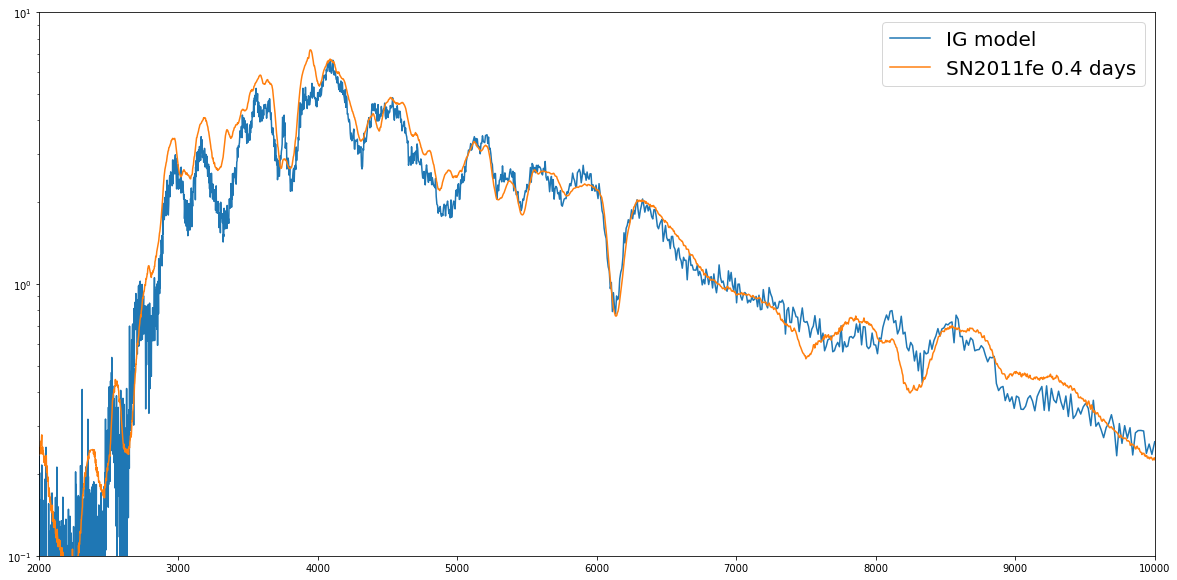

In [5]:
MDD116=np.genfromtxt('IGmodel/Element.dat')
spec=np.genfromtxt('IGmodel/Prim.ascii')
spec=Normalizer(spec)
spr=np.genfromtxt('ObserveSpectra/Prediction/SN2011fe/SN2011fe_0.4d.dat')
spr[:,0]=spr[:,0]/(1+0.000804)
spr=Normalizer(spr)
plt.plot(spec[:,0],spec[:,1],label='IG model')
plt.plot(spr[:,0],spr[:,1],label='SN2011fe 0.4 days')
plt.xlim(2000,10000)
plt.ylim(0.1,10)
plt.yscale('log')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.legend(fontsize=20)

## The Massive-Generators
Here are some functions for preparation.  
Firstly, generate the ejecta manipulation parameters, and store them into the csvs folder.  
Then, generate the yaml files and abundance files for running the TARDIS.  
In this step, the supernova structure is divided into 4 zones, and with modulation of every elements from 0 to 300% of MDD116 ejecta model. Also, the luminosity between 6500 and 7500 Angstrom is at 10^8.65~10^8.71 times of solar luminosity, explosion times and photospheric velocity changes as well.  
All the varied parameters (except the random seed) are stored in csv files.  

In [6]:
def CsvMaker(name='csvs/1.csv',num=6000):
    columns=['Lumi','Time','Vinner']+[str(i)+'_'+str(j) for i in range(6,29) for j in range(1,5)]
    data=3*np.random.random([num,len(columns)])
    data=pd.DataFrame(data,columns=columns)
    data['Lumi']=8.65+np.random.rand(num)*0.06
    data['Time']=np.random.random(num)*7+16
    veloselect=np.array([8290, 8050, 7630, 7300, 6850, 6490, 6250, 5890 ])-200 
    timeselect=np.arange(16,24)
    func=interp1d(timeselect,veloselect)
    data['Vinner']=func(data['Time'])+np.random.random(num)*240-120
    
    data['26_1']=3**(np.random.random(num)*2-1)
    data['27_1']=3**(np.random.random(num)*2-1)
    data['28_1']=3**(np.random.random(num)*2-1)
    
    data.to_csv(name,index=False)
    return
def WriteOneAbund(Element,chosenelem,zone,amplifier):
    if zone==1:Element[:19,chosenelem]=Element[:19,chosenelem]*amplifier
    if zone==2:Element[19:30,chosenelem]=Element[19:30,chosenelem]*amplifier
    if zone==3:Element[30:40,chosenelem]=Element[30:40,chosenelem]*amplifier
    if zone==4:Element[40:,chosenelem]=Element[40:,chosenelem]*amplifier
    return Element
def AbundMaker(csvname='csvs/1.csv',dirname='yaml1/'):
    data=pd.read_csv(csvname)
    for i in range(len(data)):
        Element=MDD116.copy()
        Lumi=data['Lumi'][i]
        Date=data['Time'][i]
        Velo=data['Vinner'][i]
        for j in data.columns[3:]:
            zone=int(j.split('_')[1])
            chosenelem=int(j.split('_')[0])
            amplifier=data[j][i]
            Element=WriteOneAbund(Element,chosenelem,zone,amplifier)
        Element=pd.DataFrame(Element)
        Element[0]=pd.to_numeric(Element[0],downcast='integer')
        Element.to_csv(dirname+str(i)+'.abund.dat',index=False,header=False,sep=' ')
        with open(dirname+str(i)+'.abund.dat','r+') as f:
            old=f.read()
            f.seek(0)
            f.write('# index Z=1 - Z=30\n')
            f.write(old)
        with open('DD-Sprinter.yml') as f:
            yamldata=yaml.load(f)
            yamldata['supernova']['luminosity_requested']=str(Lumi)+' log_lsun'
            yamldata['model']['structure']['v_inner_boundary']=str(Velo)+' km/s'
            yamldata['supernova']['time_explosion']=str(Date)+' day'
            yamldata['montecarlo']['seed']=np.random.randint(200000000)
            yamldata['model']['abundances']['filename']=str(i)+'.abund.dat'
            yamldata['montecarlo']['nthreads']=np.random.randint(6,14)
            yamldata['montecarlo']['last_no_of_packets']=np.random.randint(30,150)*10000
        with open(dirname+str(i)+'.yml','w') as outfile:
            yaml.dump(yamldata,outfile,default_flow_style=False)
    return


## A Simple Iteration
By running this 4-lined cell, you will create 1.csv, 2.csv, 3.csv and 4.csv in csvs folder, and 1, 2, 3, 4, four folders in Yaml folder containing [number].abund.dat and [number].yml.  
Now, every files for TARDIS running is prepared.  

In [ ]:
for i in range(1,5):
    CsvMaker(name='csvs/'+str(i)+'.csv')
    AbundMaker(csvname='csvs/'+str(i)+'.csv',dirname='Yaml/'+str(i)+'/')
    print(i)

## Let the TARDIS Run! 
I use the bash script to run TARDIS iteratively.  
When running TARDIS, only one thread will in function until the energy packet is spreading in SN ejecta, so it is okay to start multiple TARDISes and occupy all the cores for the highest time efficiency.  
Just use your terminal, move yourself into the location where "Doctor.sh" exists (it shall co-exist with this notebook) and run the code below, then everything will start.  
For this script, the first is the Yaml folder index, the secone is the start model number, the third is the end model number.  

In [ ]:
!nohup ./Doctor.sh 1 0 1000 > /dev/null &